# Best Fits in Python

Here, we will discuss how we generate "trendlines" like in Excel, except here we will do so with much more flexiblity utilizing the powerful package known as `lmfit`

## Linear regressions

Linear regressions are extremely important to experimental chemistry. A lot of measurement devices will often return unitless values, signals, voltages, etc. through analog or digital outputs. It is then up to the experimentalist to be able to analyze that data, and calibrate it properly in order to obtain any physical significance of any individual measurement.

We can have some unknown instrument response to a known quantity, such as concentration. Then, by varying the concentration and observing the change in signal, we can create a **calibration curve**. This is the basis of a lot of concentration-dependent investigations in chemistry. Additionally, you are probably already well aware of how linear best fits can allow us to determine the reaction rates of first-order rate laws.

To start, let's look at some of our previous data. In the "Manipulating Data" module, we imported and extracted data representing the peak emission intensity versus the integration time under laser excitation. Here, let's use that data to obtain a calibration curve for our emission intensity.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os

# import data
max_array = []
inttime_array = []
for filename in os.listdir('data/em_vs_laser/'): #os.listdir() will return each file in a folder.
    wavelength, intensity = np.genfromtxt(f'data/em_vs_laser/{filename}',skip_header=14,delimiter='',unpack=True) # import the data from that file
    # extract the integration time from the filename
    if 'Integration' in filename:
        print(filename)
        # truncate data to exclude possible laser peak
        intensity = intensity[(wavelength) > 575] # only fetch max from 575 nm and above, as laser peak is at 532 nm
        max_array.append(np.max(intensity))
inttime_array = [1000,20,200,2000,50,500,850]

plt.scatter(inttime_array,max_array)
plt.xlabel('integration time (ms) ')
plt.ylabel('intensity (a.u.)')
plt.title('Max intensity vs integration time')

R101 532 ex 3.41 mW Integration 550CGLP 1000 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 20 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 200 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 2000 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 50 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 500 ms.txt
R101 532 ex 3.41 mW Integration 550CGLP 850 ms.txt


Text(0.5, 1.0, 'Max intensity vs integration time')

We will be using the `lmfit` package, which we can import as follows

In [2]:
from lmfit import Model

Now we know we can extract the rate constant by a linear best fit. Using **lmfit**, we can define the function we want to fit.

For a linear equation ($y=mx + b$), we can define our equation as

In [3]:
def best_fit(x,m,b):
    y = m*x + b # write our function here
    return y

Then, we can perform a best fit using some **initial parameters**

In [4]:
# define our model based on some input function
model = Model(best_fit)

# make a best fit of our data
result = model.fit(max_array, x=inttime_array, m = 30, b = 500) # intial guesses for m and b

print(result.fit_report())

[[Model]]
    Model(best_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 7
    # variables        = 2
    chi-square         = 6080061.21
    reduced chi-square = 1216012.24
    Akaike info crit   = 99.7223062
    Bayesian info crit = 99.6141265
    R-squared          = 0.99759140
[[Variables]]
    m:  29.1372245 +/- 0.64027826 (2.20%) (init = 30)
    b:  528.737569 +/- 593.542736 (112.26%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.7120


Here, we can see all the statistical measures of our fit. The fit statistics are good to investigate and reference to see how well the fit actually performed, but the important results are in the **[[variables]]** part.

We can also plot our best fit to compare to our experimental data below

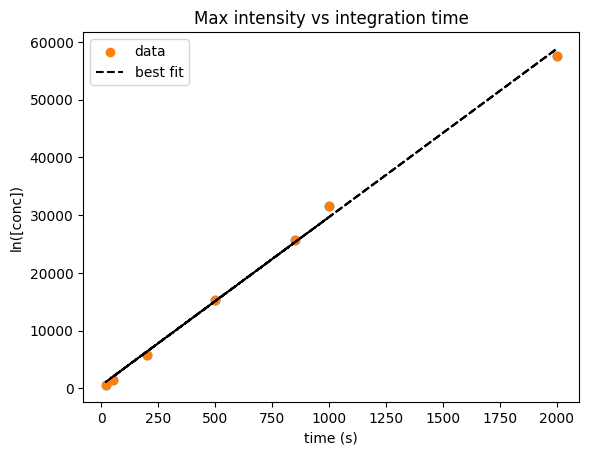

In [5]:
# plot out data on a logarithmic scale
plt.scatter(inttime_array,max_array,label = 'data')
# plot our best fit
plt.plot(inttime_array,result.best_fit, label = 'best fit', color = 'black', linestyle = '--')

# label our plot properly
plt.xlabel('time (s)')
plt.ylabel('ln([conc])')
plt.legend()
plt.show()

What we observe is a visually good fit, and we can further investigate how it varies with each data point by plotting the residuals themselves.

In [6]:
# plot the residuals
plt.scatter(inttime_array,result.residual,label = 'residuals')
plt.xlabel('integration time (ms)')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

The residuals plot is very useful, as it allows us to see how good our fit is for various data points, and also tell us (much better than a r squared value!) how well our model actually fits our data. If a linear function correctly describes the relationship we are plotting, we expect the residuals to be randomly distributed. If there is some noticeable error, we will often see a pattern in our residuals. [You can find some examples of such here on the R4EnvChem notebook](https://uoftchem-teaching.github.io/R4EnvChem/modelling-linear-regression.html#vizualizing-residuals)

## Non-Linear Regressions

`````{admonition} For CHM223 students
:class: important
This subsection is relevant for your assignment!
`````

Linear regressions are useful, but we can usually do easily in Excel. The real advantage of python and more specifically `lmfit` is it's use in fitting to **non-linear models** which vary from a simple sloped line. 

What do we mean by non-linear? Anything you could think of! Quadratic, exponential, power-law, gaussian, etc. 
To start, let's look at the hydrolysis data we plotted earlier to see if we can extract some quantities related to the rate law. We know that if the rate law is first order, taking the logarithm of the concentration over time will give us a linear trend, which we can then use to find the corrusponding rate of reaction. However, with non-linear fitting, we can just simply fit the data directly to an exponential function instead!

Remember, for a first order reaction, we expect the concentration over time to follow

$$
[\text{A}] = [\text{A}]_0 e^{-k t}
$$

Therefore, rather than taking the logarithm of our data, let's simply fit it to an exponential function!

In [7]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

time, conc_aspirin, conc_acid = np.genfromtxt('data/aspirin_data.txt',delimiter=',',skip_header=1,unpack=True)

# convert concentration to logarithmic scale
# plot our data and label
plt.scatter(time, conc_aspirin, label='Aspirin')

# label x and y axis
plt.xlabel('Time (hr)')
plt.ylabel('Concentration (M)')

# create plot title
plt.title('Aspirin Hydrolysis in an Aqueous Solution at pH 7.0 and 37 C')

# set y-axis to logarithmic scale
#plt.yscale('log')

# create legend
plt.legend()

# define fit function
def function(t,k,A):
    ### CHANGE YOUR FIT FUNCTION HERE ###
    y = A*np.exp(-k*t)
    return y

# define our model based on some input function
model = Model(function)

# make a best fit of our data
### CHANGE YOUR INITIAL GUESSES HERE ###
result = model.fit(conc_aspirin, t=time, k = 0.1, A = 0.005) # intial guesses for k and A 

print(result.fit_report())

# plot our best fit
plt.plot(time,result.best_fit, label = 'best fit', color = 'black', linestyle = '--')

# and create a plot of the residuals!
fig = plt.figure() # create a new figure

plt.scatter(time,result.residual,label = 'residuals')
plt.xlabel('Time (hr)')
plt.ylabel('Residuals')
plt.title('Residuals of Aspirin Hydrolysis in an Aqueous Solution at pH 7.0 and 37 C')

[[Model]]
    Model(function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 16
    # variables        = 2
    chi-square         = 6.4251e-10
    reduced chi-square = 4.5894e-11
    Akaike info crit   = -379.011555
    Bayesian info crit = -377.466377
    R-squared          = 0.99999045
[[Variables]]
    k:  0.00369876 +/- 6.1801e-06 (0.17%) (init = 0.1)
    A:  0.00554737 +/- 2.7270e-06 (0.05%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, A) = +0.4661


Text(0.5, 1.0, 'Residuals of Aspirin Hydrolysis in an Aqueous Solution at pH 7.0 and 37 C')

What we are able to do is directly determine the initial concentration and the rate of reaction, without doing ANY calculations ourselves to transform a linear slope into the quantity we care about.

Non-linear fitting is extremely powerful, because the possibilities for a choice of model function are endless. We've only shown one simpler example here, but you can use any functional form to fit any data that you need. [Check out this page for an interactive module utilizing lmfit with robust function selection](https://github.com/wholden/jupyter-lmfit), or the [source documentation outlining examples of built in functional forms you can use](https://lmfit.github.io/lmfit-py/builtin_models.html)

## The reality of non-linear fits: Models and Data

It is important to acknowledge that when it comes to non-linear fits, it is very easy to find a great looking fit to your data when what you're looking for is a functional form. On the other hand, a best fit is a model and just that; a model function which happens to line up with the trends in your data. But what's important to know is that it is meaningless unless there is physical, or proveable signifiance in the functional form and the coefficients. Any data you ever have will almost always fit well if you just keep adding polynomial terms. But what is significant is where those terms come from, and how we can motivate them through expected behaviour, either from theory or experiment.

For example, Quantum Dots are semiconducting nanocrystals a few nanometers in diameter that have size-tuneable absorption energies/wavelengths due to quantum confinement. We can vary the size of these nanoparticles then to achieve particles which absorb wavelengths across the visible spectrum of. This trend would be useful to know and be able to predict, and Yu et al showed that you could do this in 2003.

```{figure} images/yu_QD_sizecurve.png
---
width: 600px
---
Adapted from Yu, W. et al (2003). Experimental determination of the extinction coefficient of CdTe, CdSe, and CdS nanocrystals. Chemistry of materials, 15(14), 2854-2860.
```
```{figure} images/yu_QD_sizecurve_eqns.png
---
width: 600px
---
Adapted from Yu, W. et al (2003). Experimental determination of the extinction coefficient of CdTe, CdSe, and CdS nanocrystals. Chemistry of materials, 15(14), 2854-2860.
```

This is useful, as it allows us to predict the size from the absorption spectra alone and vice versa. But, there is an important paragraph from Yu et al. just below these equations in the source material

> "*In the above equations, D (nm) is the size of a given nanocrystal sample, and λ (nm) is the wavelength of the first  excitonic  absorption  peak  of  the  corresponding sample. **It  must  be  pointed  out  that  the  functions provided above are only polynomial fitting functions of the experimental data, which may become invalid in the size ranges not covered by the data shown in Figure 2.***"

While the fit function does a good job of tracking a trend through the data that is input, all it shows is just that; there is a trend in *this specific range of data.* For larger or smaller sizes, there is no feasible way to predict what would happen to the absorption peaks from this data alone. Furthermore, **there is absolutely nothing physical about the equations above**. There is no theory or experimental evidence involved that would imply that this is *the* functional form that best describes the size evolution of quantum dots. What it does provide is a useful tool, and it's important to remember the limits of the usefulness in fitting data.